# Fukushima Jumpei classic

> Canoncical ML pipeline


In [56]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
import pandas as pd
from pathlib import Path

from sklearn.metrics import r2_score
from uhina.loading import LoaderFactory, plot_spectra
from uhina.preprocessing import TakeDerivative, SNV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)

import plotly
import plotly.express as px
import numpy as np
from astartes import train_val_test_split

## Loading data

X shape: (635, 1675)


(<Figure size 1200x300 with 1 Axes>,
 <Axes: xlabel='Wavenumber ($cm^{-1}$)', ylabel='Absorbance'>)

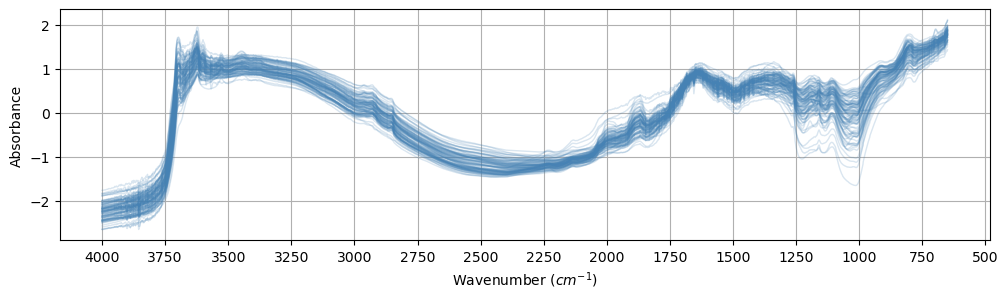

In [58]:
src = Path.home() / 'pro/data/fk-jumpei'
loader = LoaderFactory.get_loader(src, 'fk-jumpei')
data = loader.load_data()
print(f'X shape: {data.X.shape}')

plot_spectra(data, n_spectra=100, snv=True, alpha=0.2, figsize=(12, 3))

In [59]:
[d for d in dir(data) if '__' not in d]

['X',
 'X_names',
 'dataset_labels',
 'dataset_names',
 'sample_indices',
 'y',
 'y_names']

In [60]:
print(f'y_names: {data.y_names}')

y_names: ['soil_total_Cs134' 'soil_total_Cs137' 'soil_ex_Cs137'
 'exCs137_totalCs137' 'soil_water_soluble_K2O' 'soil_ex_K2O'
 'TF_plant_totalCs137' 'TF_plant_exCs137' 'soil_pH' 'soil_C' 'soil_N'
 'soil_CN_ratio' 'soil_CEC' 'soil_MgO' 'soil_CaO'
 'soil_P_absorption_coefficient' 'avaiable_Pi' 'course_sand' 'fine_sand'
 'silt' 'clay']


In [61]:
mask = ~np.isnan(data.y[:, 5])

data.X = data.X[mask, :]
data.y = data.y[mask, :]
data.sample_indices = data.sample_indices[mask]

## EDA

Visualize in PCA space:
- PCA
- Robust PCA
- Kernel PCA




In [62]:
pipe = Pipeline([
    # ('SNV', SNV()),
    ('Derivative', TakeDerivative()),
    ('Scaler', StandardScaler()),  
    ('PCA', PCA(n_components=3))])

pca = PCA(n_components=3)
data.X_pca = pipe.fit_transform(data.X)


pipe = Pipeline([
    # ('SNV', SNV()),
    ('Derivative', TakeDerivative()),
    ('Scaler', StandardScaler())
    ])
data.X_transformed = pipe.fit_transform(data.X)

(<Figure size 1200x300 with 1 Axes>,
 <Axes: xlabel='Wavenumber ($cm^{-1}$)', ylabel='Absorbance'>)

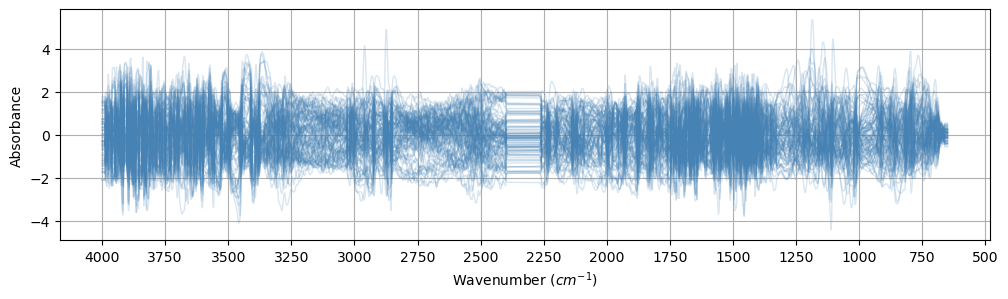

In [63]:
plot_spectra(data, var='X_transformed', n_spectra=100, snv=True, alpha=0.2, figsize=(12, 3))

In [64]:
for i, name in enumerate(data.y_names):
    print(i, name)
    

0 soil_total_Cs134
1 soil_total_Cs137
2 soil_ex_Cs137
3 exCs137_totalCs137
4 soil_water_soluble_K2O
5 soil_ex_K2O
6 TF_plant_totalCs137
7 TF_plant_exCs137
8 soil_pH
9 soil_C
10 soil_N
11 soil_CN_ratio
12 soil_CEC
13 soil_MgO
14 soil_CaO
15 soil_P_absorption_coefficient
16 avaiable_Pi
17 course_sand
18 fine_sand
19 silt
20 clay


In [65]:
def mg_100g_to_cmol_kg(x, log_tfm=False, atom_weight=39.1):
    x_mg_kg = x * 10 
    x_mg_kg_K = 0.83 * x_mg_kg
    x_cmol_kg_K = x_mg_kg_K / (atom_weight*10)
    return np.log1p(x_cmol_kg_K) if log_tfm else x_cmol_kg_K

In [66]:
data.y[:, 5] = np.log1p(mg_100g_to_cmol_kg(data.y[:, 5]))

In [67]:
def data_to_df(data, x_names=['PC1', 'PC2', 'PC3']):
    df_x = pd.DataFrame(data.X_pca, columns=x_names)

    # Create a DataFrame from data.y with column names from data.y_names
    df_y = pd.DataFrame(data.y, columns=data.y_names)

    # Concatenate the two DataFrames
    return pd.concat([df_x, df_y], axis=1)

In [68]:
data_to_df(data).head()

,PC1,PC2,PC3,soil_total_Cs134,soil_total_Cs137,soil_ex_Cs137,exCs137_totalCs137,soil_water_soluble_K2O,soil_ex_K2O,TF_plant_totalCs137,...,soil_CN_ratio,soil_CEC,soil_MgO,soil_CaO,soil_P_absorption_coefficient,avaiable_Pi,course_sand,fine_sand,silt,clay
0,-14.869968,15.920217,-4.068206,NaN,610.0,70.6,0.116,NaN,0.317439,NaN,...,12.0,29.5,64.1,339.0,1700.0,NaN,17.1,34.1,25.6,23.2
1,15.475605,-15.832351,-14.945087,NaN,273.5,27.8,0.102,NaN,0.840806,NaN,...,12.0,19.6,30.3,217.0,660.0,12.2,NaN,NaN,NaN,NaN
2,7.119297,4.821976,-12.138583,NaN,28.1,3.6,0.127,NaN,0.387556,NaN,...,12.0,13.8,38.1,96.1,640.0,6.8,NaN,NaN,NaN,NaN
3,5.582190,13.646001,-18.429360,NaN,897.8,71.4,0.080,NaN,0.538391,NaN,...,12.0,15.4,16.2,119.0,640.0,34.2,NaN,NaN,NaN,NaN
4,8.468630,12.233581,-19.155799,NaN,964.3,90.6,0.094,NaN,0.792981,NaN,...,12.0,17.7,19.9,151.0,610.0,40.0,NaN,NaN,NaN,NaN


In [69]:
def scatter3d(df, idxs=None, dot_size=15, color_by_split=False):
    """Generates a nicely formatted 3D scatter plot of the data
    optionally showing train/validation/test splits.

    Args:
        df (pd.DataFrame): DataFrame containing the data
        idxs (tuple of np.array, optional): train, validation, and
            test indexes. Defaults to None.
        dot_size (int, optional): Base size for dots. Defaults to 15.
        color_by_split (bool, optional): If True, color by split instead of soil_ex_K2O. Defaults to False.
    """
    df = df.copy()
    df['size'] = dot_size
    min_val, max_val = df['soil_ex_K2O'].min(), df['soil_ex_K2O'].max()
    plot_args = dict(
        data_frame=df,
        x="PC1",
        y="PC2",
        z="PC3",
        opacity=1,
        height=800,
        width=800,
        size='size',
        size_max=dot_size
    )

    if idxs:
        total_samples = len(df)
        size_array = [dot_size] * total_samples
        name_array = ['Unsplit'] * total_samples
        
        # Calculate relative sizes based on the number of splits
        split_sizes = [len(split) for split in idxs]
        max_split_size = max(split_sizes)
        relative_sizes = [dot_size * (1 + 2 * (size / max_split_size)) for size in split_sizes]
        
        split_names = ["Training", "Validation", "Testing"][:len(idxs)]
        
        for split, split_size, split_name in zip(idxs, relative_sizes, split_names):
            for idx in split:
                size_array[idx] = split_size
                name_array[idx] = split_name
        
        # pass these through to plotly call
        plot_args["symbol"] = "Split"
        plot_args["size"] = "MarkerSize"
        df["MarkerSize"] = np.array(size_array)
        df["Split"] = np.array(name_array)

        if color_by_split:
            plot_args["color"] = "Split"
            plot_args["color_discrete_map"] = {"Training": "#1b9e77", "Validation": "#d95f02", "Testing": "#7570b3", "Unsplit": "gray"}
        else:
            plot_args["color"] = "soil_ex_K2O"
            plot_args["range_color"] = [min_val, max_val]
    else:
        plot_args["color"] = "soil_ex_K2O"
        plot_args["range_color"] = [min_val, max_val]

    # actual call to plotly
    fig = px.scatter_3d(**plot_args)

    # add a legend for different split types
    if idxs:
        fig.update_layout(
            legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
        )
        fig.update_traces(marker=dict(line=dict(width=0)))

        # make the markers consistent between plots
        symbols = {"Training": "circle", "Validation": "diamond", "Testing": "square", "Unsplit": "circle"}
        for i, d in enumerate(fig.data):
            if d.name in symbols:
                fig.data[i].marker.symbol = symbols[d.name]

    # customize the colors
    fig.update_layout(
        dict(
            plot_bgcolor="rgba(0, 0, 0, 0)",
            paper_bgcolor="rgba(0, 0, 0, 0)",
        )
    )
    axis_args = dict(
        backgroundcolor="rgba(0, 0, 0,0)",
        gridcolor="grey",
        showbackground=True,
        zerolinecolor="grey",
    )
    fig.update_layout(scene=dict(xaxis=axis_args, yaxis=axis_args, zaxis=axis_args))

    # render the plot
    fig.show()

In [70]:
scatter3d(data_to_df(data), dot_size=15)

## Train/Valid/Test splits

Inspired from: https://jacksonburns.github.io/use-rse-23-astartes/split_comparisons.html

### Interpolative

#### Random split

In [71]:
(
    random_X_train,
    random_X_val,
    random_X_test,
    random_y_train,
    random_y_val,
    random_y_test,
    random_idxs_train,
    random_idxs_val,
    random_idxs_test,
) = train_val_test_split(
    data.X_transformed,
    data.y[:, 5],
    sampler="random",
    train_size=0.5,
    val_size=0.25,
    test_size=0.25,
    return_indices=True,
    random_state=40
)

In [72]:
scatter3d(
    data_to_df(data), 
    idxs=(random_idxs_train, random_idxs_val, random_idxs_test),
    color_by_split=True,
    dot_size=13)

#### Kennard-Stone

In [73]:
(
    ks_X_train,
    ks_X_val,
    ks_X_test,
    ks_y_train,
    ks_y_val,
    ks_y_test,
    ks_idxs_train,
    ks_idxs_val,
    ks_idxs_test,
) = train_val_test_split(
    data.X_transformed,
    data.y[:, 5],
    sampler="kennard_stone",
    train_size=0.5,
    val_size=0.25,
    test_size=0.25,
    return_indices=True,
)

In [74]:
scatter3d(
    data_to_df(data), 
    idxs=(ks_idxs_train, ks_idxs_val, ks_idxs_test),
    color_by_split=True,
    dot_size=13)

#### SPXY

In [75]:
(
    spxy_X_train,
    spxy_X_val,
    spxy_X_test,
    spxy_y_train,
    spxy_y_val,
    spxy_y_test,
    spxy_idxs_train,
    spxy_idxs_val,
    spxy_idxs_test,
) = train_val_test_split(
    data.X_transformed,
    data.y[:, 5],
    sampler="spxy",
    train_size=0.5,
    val_size=0.25,
    test_size=0.25,
    return_indices=True,
)

In [76]:
scatter3d(
    data_to_df(data), 
    idxs=(spxy_idxs_train, spxy_idxs_val, spxy_idxs_test),
    color_by_split=True,
    dot_size=13)

### Extrapolative

#### KMeans

In [77]:
(
    kmeans_X_train,
    kmeans_X_val,
    kmeans_X_test,
    kmeans_y_train,
    kmeans_y_val,
    kmeans_y_test,
    kmeans_clusters_train,
    kmeans_clusters_val,
    kmeans_clusters_test,
    kmeans_idxs_train,
    kmeans_idxs_val,
    kmeans_idxs_test,
) = train_val_test_split(
    data.X_transformed,
    data.y[:, 5],
    sampler="kmeans",
    train_size=0.5,
    val_size=0.25,
    test_size=0.25,
    return_indices=True,
    hopts=dict(n_clusters=6),
)

In [78]:
scatter3d(
    data_to_df(data), 
    idxs=(kmeans_idxs_train, kmeans_idxs_val, kmeans_idxs_test),
    color_by_split=True,
    dot_size=13)

#### Sphere exclusion

In [79]:
(
    spex_X_train,
    spex_X_val,
    spex_X_test,
    spex_y_train,
    spex_y_val,
    spex_y_test,
    spex_clusters_train,
    spex_clusters_val,
    spex_clusters_test,
    spex_idxs_train,
    spex_idxs_val,
    spex_idxs_test,
) = train_val_test_split(
    data.X_transformed,
    data.y[:, 5],
    sampler="sphere_exclusion",
    train_size=0.5,
    val_size=0.25,
    test_size=0.25,
    return_indices=True,
    hopts=dict(
        # normalized between zero and one
        distance_cutoff=0.1,
    ),
)

In [80]:
scatter3d(
    data_to_df(data), 
    idxs=(spex_idxs_train, spex_idxs_val, spex_idxs_test),
    color_by_split=True,
    dot_size=13)

#### DBSCAN

In [81]:
# (
#     dbscan_X_train,
#     dbscan_X_val,
#     dbscan_X_test,
#     dbscan_y_train,
#     dbscan_y_val,
#     dbscan_y_test,
#     dbscan_clusters_train,
#     dbscan_clusters_val,
#     dbscan_clusters_test,
#     dbscan_idxs_train,
#     dbscan_idxs_val,
#     dbscan_idxs_test,
# ) = train_val_test_split(
#     data.X_transformed,
#     data.y[:, 5],
#     sampler="dbscan",
#     train_size=0.5,
#     val_size=0.25,
#     test_size=0.25,
#     return_indices=True,
#     hopts=dict(
#         eps=100,
#     ),
# )

## Training

In [82]:
def get_split_data(split_type):
    split_names = ['X_train', 'X_val', 'X_test', 'y_train', 'y_val', 'y_test', 'idxs_train', 'idxs_val', 'idxs_test']
    return {name: globals().get(f"{split_type}_{name}") for name in split_names}

split_types = ['random', 'ks', 'spxy', 'kmeans', 'spex']

def get_data_for_split(split_type):
    if split_type not in split_types:
        raise ValueError(f"Invalid split type. Choose from: {', '.join(split_types)}")
    
    split_data = get_split_data(split_type)
    
    return (
        split_data['X_train'], split_data['X_val'], split_data['X_test'],
        split_data['y_train'], split_data['y_val'], split_data['y_test'],
        split_data['idxs_train'], split_data['idxs_val'], split_data['idxs_test']
    )

In [87]:
split_type = 'ks'  # or any other split type

(
    X_train, 
    X_val, 
    X_test, 
    y_train, 
    y_val, 
    y_test, 
    idxs_train, 
    idxs_val, 
    idxs_test
) = get_data_for_split(split_type)

100%|██████████| 19/19 [00:00<00:00, 25.93it/s]


Best score: 0.33593208396890584 at n=12


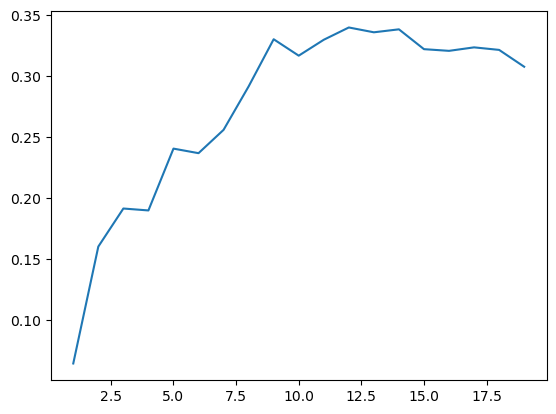

In [88]:
from sklearn.cross_decomposition import PLSRegression
from tqdm.auto import tqdm

scores = []
n_max = 20
for n in tqdm(range(1,n_max)):
    pls = PLSRegression(n_components=n)
    pls.fit(X_train, y_train)
    y_val_predicted = pls.predict(X_val)
    scores.append(r2_score(y_val, y_val_predicted))

plt.plot(range(1, n_max), scores)
n_best = np.argmax(np.array(scores)) + 1
print(f'Best score: {scores[n_best]} at n={n_best}')
# plt.ylim(0, 1)

In [89]:
# ON TEST SET
pls = PLSRegression(n_components=n_best)
pls.fit(X_train, y_train)
y_test_predicted = pls.predict(X_test)
r2_score(y_test, y_test_predicted)

0.006008064304613536

In [ ]:
src = '../../_data/fk-jumpei-tfm/im-targets-lut.csv'
df = pd.read_csv(src)
print(f'{df.shape[0]} samples')
df.head()

635 samples


,fname,soil_total_Cs134,soil_total_Cs137,soil_ex_Cs137,exCs137_totalCs137,soil_water_soluble_K2O,soil_ex_K2O,TF_plant_totalCs137,TF_plant_exCs137,soil_pH,...,soil_CN_ratio,soil_CEC,soil_MgO,soil_CaO,soil_P_absorption_coefficient,avaiable_Pi,course_sand,fine_sand,silt,clay
0,20-2013-paddy_rice.png,NaN,610.0,70.6,0.116,NaN,17.6,NaN,NaN,6.0,...,12.0,29.5,64.1,339.0,1700.0,NaN,17.1,34.1,25.6,23.2
1,28-2014-paddy_rice.png,NaN,273.5,27.8,0.102,NaN,62.1,NaN,NaN,5.0,...,12.0,19.6,30.3,217.0,660.0,12.2,NaN,NaN,NaN,NaN
2,33-2014-paddy_rice.png,NaN,28.1,3.6,0.127,NaN,22.3,NaN,NaN,6.0,...,12.0,13.8,38.1,96.1,640.0,6.8,NaN,NaN,NaN,NaN
3,35-2014-paddy_rice.png,NaN,897.8,71.4,0.080,NaN,33.6,NaN,NaN,5.0,...,12.0,15.4,16.2,119.0,640.0,34.2,NaN,NaN,NaN,NaN
4,36-2014-paddy_rice.png,NaN,964.3,90.6,0.094,NaN,57.0,NaN,NaN,5.0,...,12.0,17.7,19.9,151.0,610.0,40.0,NaN,NaN,NaN,NaN


In [ ]:
def mg_100g_to_cmol_kg(x, log_tfm=False, atom_weight=39.1):
    x_mg_kg = x * 10 
    x_mg_kg_K = 0.83 * x_mg_kg
    x_cmol_kg_K = x_mg_kg_K / (atom_weight*10)
    return np.log1p(x_cmol_kg_K) if log_tfm else x_cmol_kg_K

<Axes: >

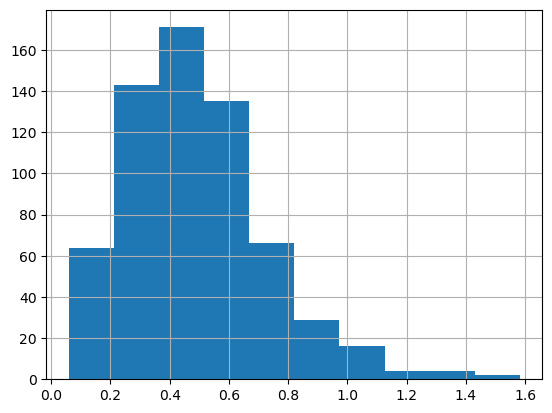

In [ ]:
mg_100g_to_cmol_kg(df['soil_ex_K2O'], log_tfm=True).hist()

In [ ]:
print('Before:', df.shape)
df.dropna(inplace=True, subset=['soil_ex_K2O'])
print('After:', df.shape)

Before: (635, 22)
After: (634, 22)


<Axes: >

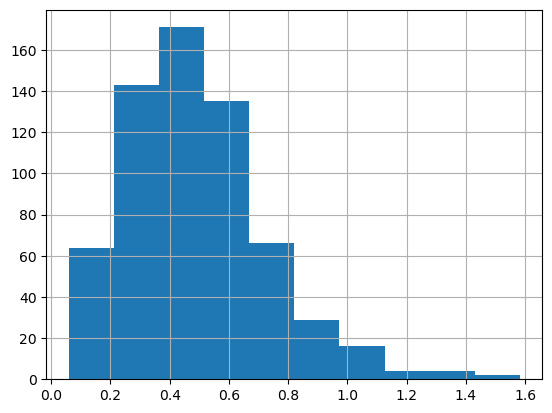

In [ ]:
 df['soil_ex_K2O'] = df['soil_ex_K2O'].apply(lambda x: mg_100g_to_cmol_kg(x, log_tfm=True))
 df.soil_ex_K2O.hist()

In [ ]:
for i, col in enumerate(df.columns):
    print(f'{i}: {col}')

0: fname
1: soil_total_Cs134
2: soil_total_Cs137
3: soil_ex_Cs137
4: exCs137_totalCs137
5: soil_water_soluble_K2O
6: soil_ex_K2O
7: TF_plant_totalCs137
8: TF_plant_exCs137
9: soil_pH
10: soil_C
11: soil_N
12: soil_CN_ratio
13: soil_CEC
14: soil_MgO
15: soil_CaO
16: soil_P_absorption_coefficient
17: avaiable_Pi
18: course_sand
19: fine_sand
20: silt
21: clay


## Fine-tuning

In [ ]:
class OrderedQuantize(Quantize):
    order = 0  # Apply first

class OrderedRatioResize(RatioResize):
    order = 1  # Apply second

In [ ]:
def stratified_split(df, target, valid_size=0.2, test_size=0.2, num_bins=2, seed=41):
    from sklearn.model_selection import train_test_split
    df = df.copy()
    df.reset_index(inplace=True, drop=True)
    train_df, test_df = train_test_split(df, test_size=test_size, 
                                        stratify=pd.qcut(df[target], q=num_bins, labels=False), 
                                        random_state=seed)

    train_df, valid_df = train_test_split(train_df, test_size=valid_size, 
                                        stratify=pd.qcut(train_df[target], q=num_bins, labels=False), 
                                        random_state=seed)
    
    return train_df, train_df.index, valid_df, valid_df.index, test_df, test_df.index

In [ ]:
# from sklearn.model_selection import StratifiedShuffleSplit

# def stratified_split(df, target_col, n_bins=2, n_splits=2, test_size=0.2, random_state=42):
#     # Create bins for the target values
#     df_copy = df.copy()
#     df_copy['target_bin'] = pd.cut(df_copy[target_col], bins=n_bins, labels=False)
    
#     # Create a StratifiedShuffleSplit object
#     sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    
#     # Get the indices for the splits
#     splits = list(sss.split(df_copy, df_copy['target_bin']))
    
#     # Remove the temporary 'target_bin' column
#     df_copy.drop('target_bin', axis=1, inplace=True)
    
#     return splits

In [ ]:
df.head()

,fname,soil_total_Cs134,soil_total_Cs137,soil_ex_Cs137,exCs137_totalCs137,soil_water_soluble_K2O,soil_ex_K2O,TF_plant_totalCs137,TF_plant_exCs137,soil_pH,...,soil_CN_ratio,soil_CEC,soil_MgO,soil_CaO,soil_P_absorption_coefficient,avaiable_Pi,course_sand,fine_sand,silt,clay
0,20-2013-paddy_rice.png,NaN,610.0,70.6,0.116,NaN,0.317439,NaN,NaN,6.0,...,12.0,29.5,64.1,339.0,1700.0,NaN,17.1,34.1,25.6,23.2
1,28-2014-paddy_rice.png,NaN,273.5,27.8,0.102,NaN,0.840806,NaN,NaN,5.0,...,12.0,19.6,30.3,217.0,660.0,12.2,NaN,NaN,NaN,NaN
2,33-2014-paddy_rice.png,NaN,28.1,3.6,0.127,NaN,0.387556,NaN,NaN,6.0,...,12.0,13.8,38.1,96.1,640.0,6.8,NaN,NaN,NaN,NaN
3,35-2014-paddy_rice.png,NaN,897.8,71.4,0.080,NaN,0.538391,NaN,NaN,5.0,...,12.0,15.4,16.2,119.0,640.0,34.2,NaN,NaN,NaN,NaN
4,36-2014-paddy_rice.png,NaN,964.3,90.6,0.094,NaN,0.792981,NaN,NaN,5.0,...,12.0,17.7,19.9,151.0,610.0,40.0,NaN,NaN,NaN,NaN


In [ ]:
idx = 6
df.columns[idx]

'soil_ex_K2O'

In [ ]:
data = stratified_split(df,  df.columns[idx], valid_size=0.2, test_size=0.2, num_bins=2)
train_df, train_idx, valid_df, valid_idx, test_df, test_idx = data

In [ ]:
# # Usage example:
# splits = stratified_split(df, df.columns[idx], n_bins=4, n_splits=2, random_state=41)

# # For train-validation split
# train_idx, valid_idx = splits[0]

# # For train-test split (if needed)
# train_valid_idx, test_idx = splits[1]

# # Create DataFrames
# train_df = df.iloc[train_idx]
# valid_df = df.iloc[valid_idx]
# test_df = df.iloc[test_idx]

In [ ]:
len(train_df), len(valid_df), len(test_df)

(405, 102, 127)

In [ ]:
test_df[['fname', df.columns[idx]]]

,fname,soil_ex_K2O
195,758-2014-soybean.png,0.973526
77,166-2016-paddy_rice.png,0.571297
224,888-2014-paddy_rice.png,0.329727
580,2391-2020-paddy_rice.png,0.519631
10,51-2015-paddy_rice.png,0.204683
...,...,...
520,2131-2018-paddy_rice.png,0.473116
321,1352-2014-paddy_rice.png,0.739718
226,908-2014-paddy_rice.png,0.202951
137,250-2017-paddy_rice.png,0.095101


<Axes: >

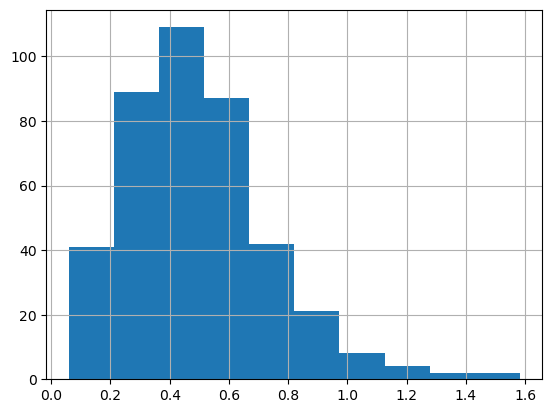

In [ ]:
train_df['soil_ex_K2O'].hist()

<Axes: >

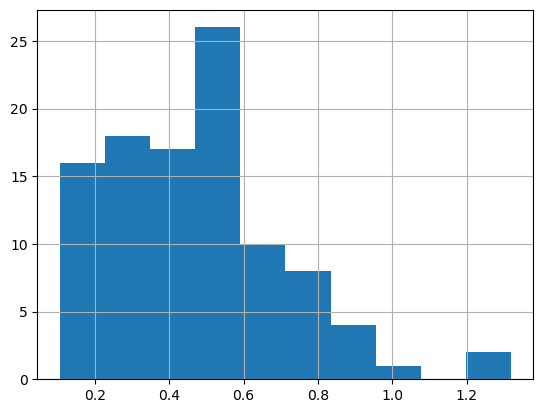

In [ ]:
valid_df['soil_ex_K2O'].hist()

<Axes: >

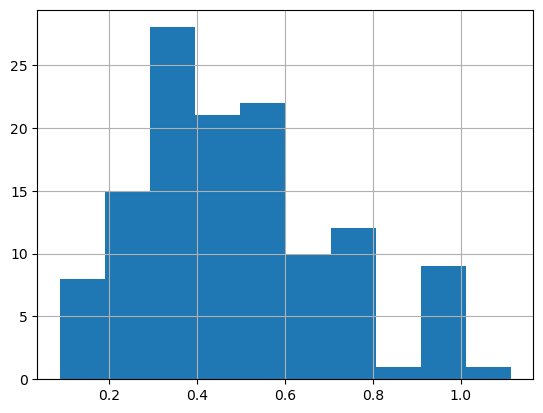

In [ ]:
test_df['soil_ex_K2O'].hist()

In [ ]:
def stratified_splitter(items):
    return [train_idx, valid_idx]

In [ ]:
len(train_idx), len(valid_idx), len(test_idx)

(405, 102, 127)

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(0, pref='../../_data/fk-jumpei-tfm/im/'),
    get_y=ColReader(6),
    splitter=stratified_splitter,
    item_tfms=[OrderedQuantize(n_valid=len(valid_idx))],
    batch_tfms=[
        OrderedRatioResize(224),
        Normalize.from_stats(*imagenet_stats)
    ]
)

In [ ]:
# dblock = DataBlock(blocks=(ImageBlock, RegressionBlock),
#                    get_x=ColReader(0, pref='../../_data/fk-jumpei-tfm/im/'),
#                    get_y=ColReader(idx),
#                    splitter=stratified_splitter,
#                    batch_tfms=[RatioResize(224)],
#                    item_tfms=[Quantize(n_valid=len(valid_idx))])

# # dblock.summary(df)

In [ ]:
dls = dblock.dataloaders(df, bs=16)

In [ ]:
dls.train.n, dls.valid.n

(405, 102)

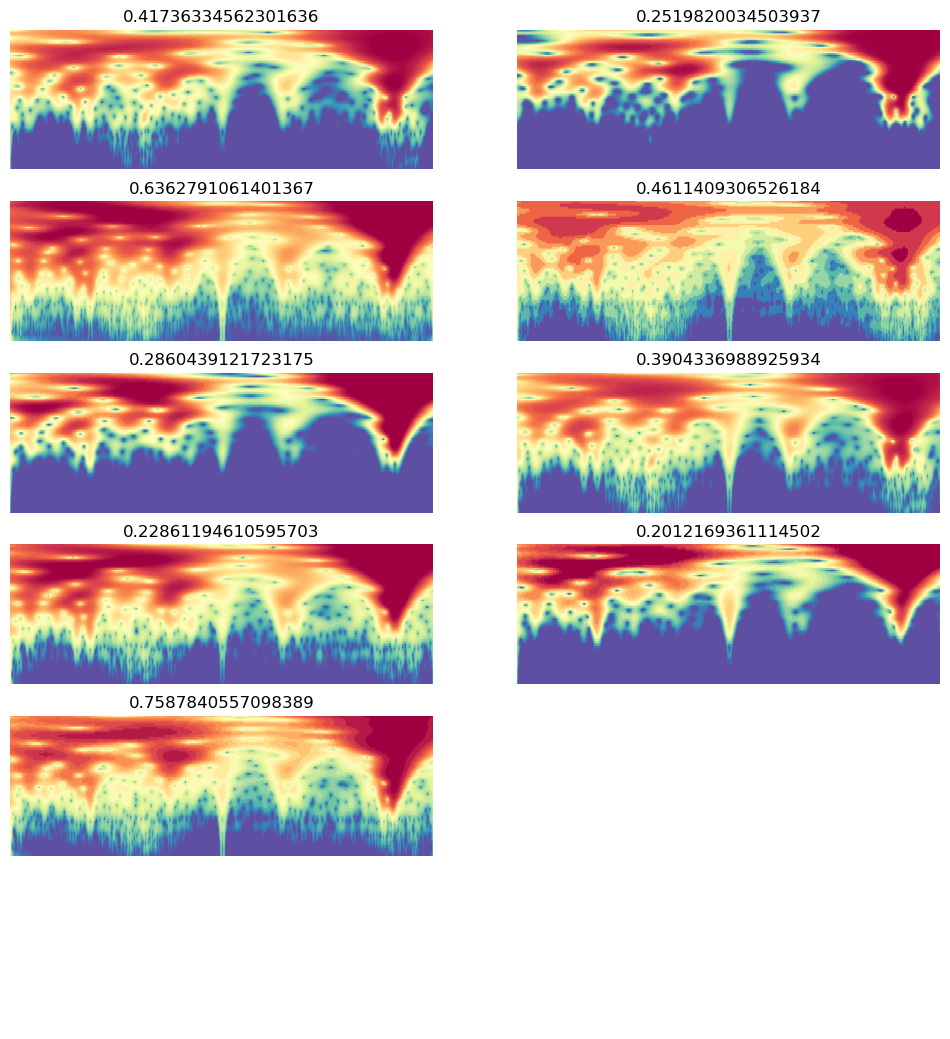

In [ ]:
dls.show_batch(nrows=6, ncols=2, figsize=(12, 13))

In [ ]:
# learn = load_learner('./models/650-4000-epoch-25-lr-3e-3.pkl', cpu=True)
learn = load_learner('./models/unfrozen-epoch-30-lr-1.5e-3-12102024.pkl', cpu=True)
# learn = load_learner('./models/frozen-epoch-30-lr-1.5e-3-12102024.pkl', cpu=True)

In [ ]:
learn.dls = dls

In [ ]:
# learn.summary()

In [ ]:
learn.freeze()

In [ ]:
# learn.model[-1][-1]

In [ ]:
# model = learn.model
# last_layer = model[-1][-1]
# new_layer = nn.Linear(in_features=last_layer.in_features, 
#                       out_features=last_layer.out_features, 
#                       bias=True)
# new_layer.weight.data = last_layer.weight.data
# if hasattr(last_layer, 'bias') and last_layer.bias is not None:
#     new_layer.bias.data = last_layer.bias.data
# learn.model[-1][-1] = new_layer

In [ ]:
# learn.model[-1][-1]

SuggestedLRs(valley=0.0003981071640737355)

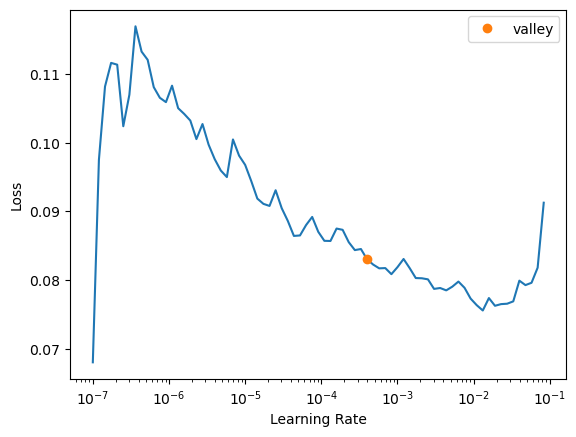

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20, 4e-4)

epoch,train_loss,valid_loss,r2_score,time
0,0.085307,0.063526,-0.155087,00:21
1,0.073202,0.090788,-0.650800,00:21
2,0.064845,0.056194,-0.021780,00:22
3,0.058440,0.168733,-2.068068,00:22
4,0.057954,0.169698,-2.085604,00:22
5,0.058297,0.072166,-0.312190,00:24


KeyboardInterrupt: 

In [ ]:
val_preds, val_targets = learn.get_preds(dl=dls.valid)
r2_score(val_targets, val_preds)

0.23469541349548861

In [ ]:
learn.unfreeze()

SuggestedLRs(valley=5.248074739938602e-05)

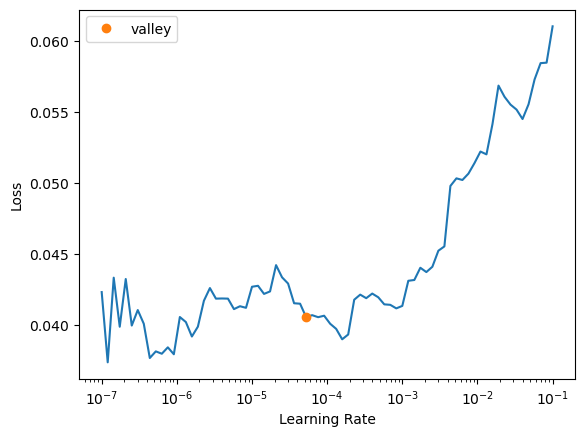

In [ ]:
learn.lr_find()

In [ ]:
# learn.fit_one_cycle(20, slice(1e-5, 1.5e-3))
learn.fit_one_cycle(20, 1.5e-3)

epoch,train_loss,valid_loss,r2_score,time
0,0.043800,0.053276,0.031285,00:22
1,0.046924,0.054486,0.009281,00:21
2,0.051729,0.184493,-2.354623,00:21


KeyboardInterrupt: 

In [ ]:
val_preds, val_targets = learn.get_preds(dl=dls.valid)
r2_score(val_targets, val_preds)

0.36861295616974843

### Evaluate fine-tuned model

In [ ]:
len(test_df)

127

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, RegressionBlock),
                   get_x=ColReader(0, pref='../../_data/fk-jumpei-tfm/im/'),
                   get_y=ColReader(idx),
                   splitter=RandomSplitter(valid_pct=0, seed=41),
                   batch_tfms=[RatioResize(224)],
                   item_tfms=[Quantize(n_valid=len(test_df))])

dls = dblock.dataloaders(test_df, bs=len(test_df))

In [ ]:
val_preds, val_targets = learn.get_preds(dl=dls.train)

In [ ]:
r2_score(val_targets, val_preds)

-0.012676790057743803

In [ ]:
val_preds, val_targets = learn.tta(dl=dls.train, n=30)

KeyboardInterrupt: 

In [ ]:
np.c_[val_preds, val_targets][:10]

array([[0.6631091 , 0.7696582 ],
       [0.45307112, 0.5359099 ],
       [0.28646332, 0.25363058],
       [0.891094  , 0.96547544],
       [0.47445062, 0.54948056],
       [1.4899724 , 1.4513922 ],
       [0.3082603 , 0.25363058],
       [0.41703525, 0.27481836],
       [0.42921203, 0.4435868 ],
       [0.77836686, 0.80633885]], dtype=float32)

[<matplotlib.lines.Line2D>]

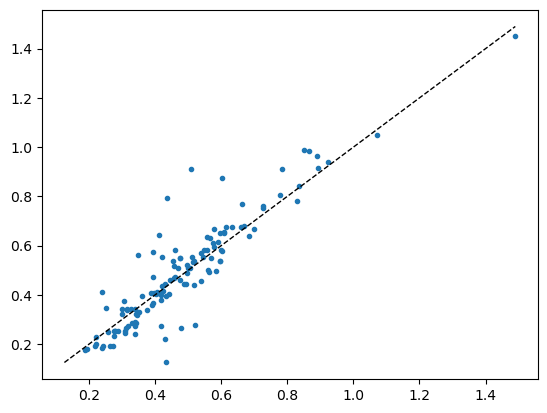

In [ ]:
x, y = val_preds, val_targets
plt.plot(x, y, '.')
# Add the diagonal line
min_val = min(y.min(), x.min())
max_val = max(y.max(), x.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)

In [ ]:
r2_score(val_targets, val_preds)

0.8264008364793762

### On single images

In [ ]:
def predict_with_transforms(learn, img_path, n_predictions=5):
    # Load the image
    img = PILImage.create(img_path)
    
    # Create instances of the transforms
    ratio_resize = RatioResize(224)
    quantize = Quantize()
    
    predictions = []
    for _ in range(n_predictions):
        # Apply transforms
        img_resized = ratio_resize(img)
        img_quantized = quantize(img_resized)
        
        # Predict
        pred, _, _ = learn.predict(img_quantized)
        predictions.append(pred[0])
    
    from statistics import mode
    # Calculate mean and standard deviation
    mean_pred = np.mean(predictions)
    std_pred = np.std(predictions)
    median_pred = np.median(predictions)
    mode_pred = mode(predictions)
    return mean_pred, std_pred, median_pred, mode_pred, predictions

In [ ]:
test_df[['fname', df.columns[idx]]]

,fname,soil_ex_K2O
217,859-2014-paddy_rice.png,0.539629
163,278-2018-paddy_rice.png,0.341865
243,968-2014-paddy_rice.png,0.578465
467,2076-2018-paddy_rice.png,0.338844
513,2123-2018-paddy_rice.png,1.048431
...,...,...
605,2419-2020-paddy_rice.png,0.274818
352,1473-2014-paddy_rice.png,0.407526
0,20-2013-paddy_rice.png,0.317439
355,1477-2014-paddy_rice.png,0.337330


In [ ]:
learn.predict('/Users/franckalbinet/pro/dev/uhina/_data/fk-jumpei-tfm/im/859-2014-paddy_rice.png')

((0.5223042368888855,), tensor([0.5223]), tensor([0.5223]))

In [ ]:
def predict_with_tta_histogram(learn, img_path, n_tta=30):
    # Load the image
    img = PILImage.create(img_path)
    
    # Create a test DataLoader with a single image
    test_dl = learn.dls.test_dl([img])
    
    # Collect predictions
    all_preds = []
    for _ in range(n_tta):
        # Get prediction with TTA (n=1 for a single augmentation each time)
        preds, _ = learn.tta(dl=test_dl, n=1)
        all_preds.append(preds[0][0].item())  # Assuming single output
    
    all_preds = np.array(all_preds)
    
    # Calculate statistics
    mean_pred = np.mean(all_preds)
    std_pred = np.std(all_preds)
    median_pred = np.median(all_preds)
    min_pred = np.min(all_preds)
    max_pred = np.max(all_preds)
    
    return mean_pred, std_pred, median_pred, min_pred, max_pred, all_preds

Min prediction: 0.4531
Max prediction: 0.5795
Mean prediction: 0.5275
Standard deviation: 0.0282
Median prediction: 0.5272
All predictions: [0.54436386 0.55598998 0.56092638 0.57104981 0.52798319 0.57950228
 0.50701064 0.52194297 0.51890564 0.53010362 0.50141889 0.53311121
 0.51312613 0.53879243 0.50901508 0.51508129 0.54903734 0.51155448
 0.53831923 0.50822324 0.52851534 0.57572448 0.51641762 0.51522946
 0.45307761 0.52632904 0.53577548 0.56359959 0.51006508 0.46458086]
Ground truth: 0.5396292928049117


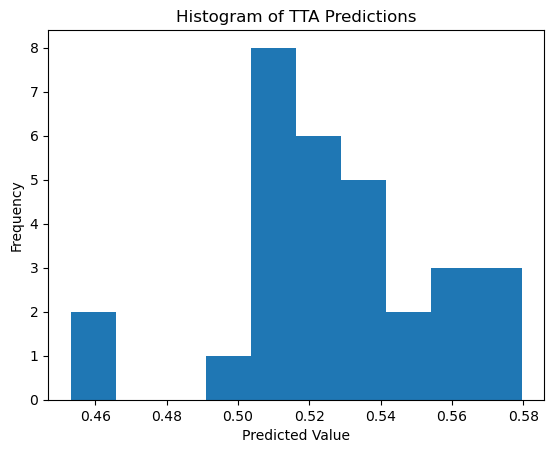

In [ ]:

# Use the function
fname = '859-2014-paddy_rice.png'
img_path = Path('/Users/franckalbinet/pro/dev/uhina/_data/fk-jumpei-tfm/im/') / fname
mean, std, median, min_pred, max_pred, all_preds = predict_with_tta_histogram(learn, img_path, n_tta=30)

print(f"Min prediction: {min_pred:.4f}")
print(f"Max prediction: {max_pred:.4f}")
print(f"Mean prediction: {mean:.4f}")
print(f"Standard deviation: {std:.4f}")
print(f"Median prediction: {median:.4f}")
print(f"All predictions: {all_preds}")

# If you want to compare with the ground truth
print('Ground truth:', df[df.fname == fname][df.columns[idx]].values[0])

# Plot histogram
plt.hist(all_preds, bins=10)
plt.title('Histogram of TTA Predictions')
plt.xlabel('Predicted Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Canonical fine-tuning
# from fastai.vision.all import *

# # Load the pretrained model
# learn = load_learner('./models/650-4000-epoch-25-lr-3e-3.pkl', cpu=False)

# # Prepare your new data
# path = 'path/to/your/data'
# dls = ImageDataLoaders.from_folder(path, valid_pct=0.2, item_tfms=Resize(224), batch_tfms=aug_transforms())

# # Set the new data
# learn.dls = dls

# # Fine-tune the head of the model
# learn.freeze()
# # alternatively: learn.freeze_to(n)
# learn.lr_find()
# learn.fit_one_cycle(5, 3e-3)

# # Fine-tune the entire model
# learn.unfreeze()
# learn.lr_find()
# learn.fit_one_cycle(5, slice(1e-5, 1e-3))

In [ ]:
# learn = vision_learner(dls, resnet18, pretrained=False, metrics=R2Score()).to_fp16()


In [ ]:
# learn.lr_find()

SuggestedLRs(valley=0.002511886414140463)

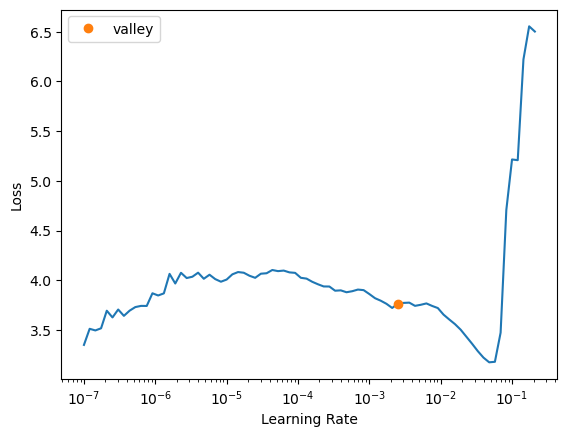

In [ ]:
# learn.lr_find()

In [ ]:
# learn.fit_one_cycle(5, 3e-3)

## Evaluation

In [ ]:
# Convert predictions and targets to numpy arrays
def assess_model(val_preds, val_targets):
    val_preds = val_preds.numpy().flatten()
    val_targets = val_targets.numpy()

    # Create a DataFrame with the results
    results_df = pd.DataFrame({
        'Predicted': val_preds,
        'Actual': val_targets
    })

    # Display the first few rows of the results
    print(results_df.head())

    # Calculate and print the R2 score
    from sklearn.metrics import r2_score
    r2 = r2_score(val_targets, val_preds)
    print(f"R2 Score on validation set: {r2:.4f}")

In [ ]:
dls.train.n

69

In [ ]:
val_preds, val_targets = learn.get_preds(dl=dls.train)
assess_model(val_preds, val_targets)

   Predicted    Actual
0   0.046272  0.210804
1   0.528189  0.976900
2   0.465372  0.469860
3   0.258100  0.338556
4   0.112802  0.147696
R2 Score on validation set: 0.7392


In [ ]:
val_preds, val_targets = learn.get_preds(dl=dls.train)
r2 = r2_score(val_targets, val_preds); r2

In [ ]:
r2 = r2_score(val_targets, val_preds); r2

0.7391959435205914

In [ ]:
scores = []
for n in range(1, 20):
    val_preds, val_targets = learn.tta(dl=dls.train, n=n)
    scores.append(r2_score(val_targets, val_preds))

[<matplotlib.lines.Line2D>]

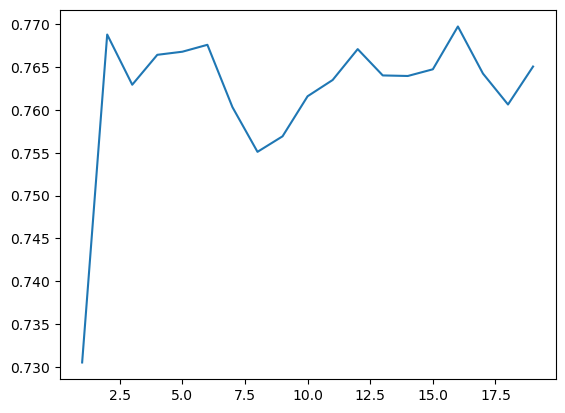

In [ ]:
x = list(range(1, 20))
plt.plot(x, scores)

In [ ]:
# EXAMPLE of TTA on single item
# from fastai.vision.all import *

# # Define your TTA transforms
# tta_tfms = [
#     RandomResizedCrop(224, min_scale=0.5),
#     Flip(),
#     Rotate(degrees=(-15, 15)),
#     Brightness(max_lighting=0.2),
#     Contrast(max_lighting=0.2)
# ]

# # Create a pipeline of TTA transformations
# tta_pipeline = Pipeline(tta_tfms)

# # Load your model
# learn = load_learner('path/to/your/model.pkl')

# # Define the input data (e.g., an image)
# input_data = PILImage.create('path/to/your/image.jpg')

# # Apply TTA transforms to the input data and make predictions
# predictions = []
# for _ in range(5):  # Apply 5 different augmentations
#     augmented_data = tta_pipeline(input_data)
#     prediction = learn.predict(augmented_data)
#     predictions.append(prediction)

# # Average the predictions
# average_prediction = sum(predictions) / len(predictions)

# print(average_prediction)

In [ ]:
# Assuming you have a new CSV file for your test data
# test_source = '../../_data/ossl-tfm/ossl-tfm-test.csv'
# test_df = pd.read_csv(test_source)

# # Create a new DataLoader for the test data
# test_dl = learn.dls.test_dl(test_df)

# # Get predictions on the test set
# test_preds, test_targets = learn.get_preds(dl=test_dl)

# # Now you can use test_preds and test_targets for further analysis

In [ ]:
assess_model(val_preds, val_targets)

   Predicted    Actual
0   0.312483  0.000000
1   0.126990  0.184960
2   0.365726  0.194201
3   0.239089  0.262364
4   0.402980  0.355799
R2 Score on validation set: 0.8325


In [ ]:
assess_model(val_preds_tta, val_targets_tta)

   Predicted    Actual
0   0.246857  0.000000
1   0.148590  0.184960
2   0.371643  0.194201
3   0.226535  0.262364
4   0.407333  0.355799
R2 Score on validation set: 0.8378


In [ ]:
val_preds_np = val_preds
val_targets_np = val_targets

# Apply the transformation: exp(y) - 1
val_preds_transformed = np.exp(val_preds_np) - 1
val_targets_transformed = np.exp(val_targets_np) - 1

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Predicted': val_preds_transformed,
    'Actual': val_targets_transformed
})

# Display the first few rows of the results
print(results_df.head())

# Calculate and print the R2 score
from sklearn.metrics import r2_score
r2 = r2_score(val_targets_transformed, val_preds_transformed)
print(f"R2 Score on validation set (after transformation): {r2:.4f}")

# Calculate and print the MAPE, handling zero values
def mean_absolute_percentage_error(y_true, y_pred):
    non_zero = (y_true != 0)
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

mape = mean_absolute_percentage_error(val_targets_transformed, val_preds_transformed)
print(f"Mean Absolute Percentage Error (MAPE) on validation set: {mape:.2f}%")

# Calculate and print the MAE as an alternative metric
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(val_targets_transformed, val_preds_transformed)
print(f"Mean Absolute Error (MAE) on validation set: {mae:.4f}")

   Predicted   Actual
0   0.366814  0.00000
1   0.135405  0.20317
2   0.441560  0.21434
3   0.270092  0.30000
4   0.496277  0.42732
R2 Score on validation set (after transformation): 0.6936
Mean Absolute Percentage Error (MAPE) on validation set: 50.72%
Mean Absolute Error (MAE) on validation set: 0.1956


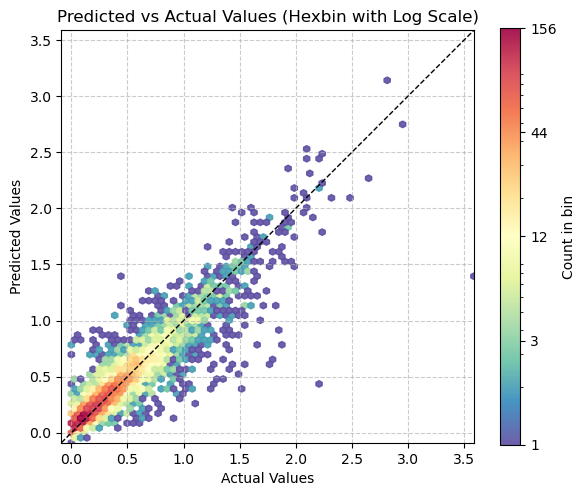

Min non-zero count in hexbins: 1.0
Max count in hexbins: 157.0


In [ ]:
plt.figure(figsize=(6, 6))

# Use logarithmic bins for the colormap
h = plt.hexbin(val_targets, val_preds, gridsize=65, 
               bins='log', cmap='Spectral_r', mincnt=1,
               alpha=0.9)

# Get the actual min and max counts from the hexbin data
counts = h.get_array()
min_count = counts[counts > 0].min()  # Minimum non-zero count
max_count = counts.max()

# Create a logarithmic colorbar
cb = plt.colorbar(h, label='Count in bin', shrink=0.73)
tick_locations = np.logspace(np.log10(min_count), np.log10(max_count), 5)
cb.set_ticks(tick_locations)
cb.set_ticklabels([f'{int(x)}' for x in tick_locations])

# Add the diagonal line
min_val = min(val_targets.min(), val_preds.min())
max_val = max(val_targets.max(), val_preds.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)

# Set labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (Hexbin with Log Scale)')

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.65)

# Set the same limits for both axes
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

# Make the plot square
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

# Print the range of counts in the hexbins
print(f"Min non-zero count in hexbins: {min_count}")
print(f"Max count in hexbins: {max_count}")

In [ ]:
path_model = Path('./models')
learn.export(path_model / '0.pkl')

## Inference

In [ ]:
ossl_source = Path('../../_data/ossl-tfm/img')
learn.predict(ossl_source / '0a0a0c647671fd3030cc13ba5432eb88.png')

((0.5229991674423218,), tensor([0.5230]), tensor([0.5230]))

In [ ]:
df[df['fname'] == '0a0a0c647671fd3030cc13ba5432eb88.png']

,fname,kex
28867,0a0a0c647671fd3030cc13ba5432eb88.png,0.525379
